In [1]:
%load_ext autoreload
%matplotlib inline

import hdf5storage # you need to pip install this to handle matlab > 7.3 files or something
import numpy as np
from fooof import FOOOFGroup, fit_fooof_group_3d
from fooof.funcs import combine_fooofs
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import sys
sys.path.append('../')
import echo_utils

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_folder = '/Users/rdgao/Documents/data/CRCNS/Johnson/'
result_basepath = '/Users/rdgao/Documents/code/research/field-echos/results/johnson/'
df_patient_info = pd.read_csv(data_folder+'patient_info_combined.csv', index_col=0)
df_electrode_info = pd.read_csv(data_folder+'electrode_info_combined.csv')

# save metadata to saved data folder for easier access
df_patient_info.to_csv('../data/df_johnson_patient_info.csv')
df_electrode_info.to_csv('../data/df_johnson_electrode_info.csv')


# get all subjects
all_subjs = df_patient_info.index.values.astype(str)

# there are the three datatypes in the mat file
data_types = ['data_pre', 'data_encmain', 'data_proc']
n_types = np.shape(data_types)[0]

# these are the time windows Johnson et al. used
# note that I'm keep all the windows 900ms so the knee-fits are all using the same amount of data
# but we will average taus from the two delay periods since we just want to check delay versus pre-stim
trial_time_wins = [[-0.9, 0.0], [0.6, 1.5], [0.3, 1.2]]

# FOOOF settings
freq_range = [2, 80] # this is the range gao uses
bw_lims = [2, 8]
max_n_peaks = 2 # single-trial fits are so noisy so this isn't super critical

### Compute and Save PSDs

In [3]:
for i_sub, sub in enumerate(all_subjs):
    print(sub, end=' |')
    # load data file
    filepath = data_folder + sub + '/data_derived.mat'
    mat = hdf5storage.loadmat(filepath)

    # get subject-specific sampling rate
    fs = df_patient_info.loc[sub]['sampling_rate']
    
    chan_names = np.squeeze(mat[data_types[0]]['label'].tolist()).tolist() # full list of channels
    frontal_chans = df_electrode_info[(df_electrode_info['patient']==sub) & ((df_electrode_info['region']=='PFC') | (df_electrode_info['region']=='OFC'))]['electrode'].values.astype(str)
    n_chans = np.shape(frontal_chans)[0] # number of PFC+OFC channels

    # find indices of frontal channels in full channel list
    chans_idx = [chan_names.index(chan) for chan in frontal_chans]

    # get the number of trials, for initializing data arrays
    n_trials = np.shape(np.squeeze(mat[data_types[0]]['trial']))[0]

    # get time vector from data matrix
    t = np.asarray(np.squeeze(mat[data_types[0]]['time'].tolist()).tolist()[0])

    power_spec_all = []
    for i_cond in range(len(data_types)):
        # restrict to proper time windows for this condition
        period_idx = [np.where(t>=trial_time_wins[i_cond][i_period])[0][0] for i_period in range(2)]

        # grab condition data and gather only the relevant time points & channels
        cond_data = np.squeeze(mat[data_types[i_cond]]['trial']).tolist()

        # here, trial_data.shape = trial x channel x time
        trial_data = np.array([cond_data[tr][chans_idx, period_idx[0]:period_idx[1]] for tr in range(n_trials)])
        n_points = trial_data.shape[2] # of timepoints in trial

        # mean-subtract from time average per trial, and apply hamming window
        data_windowed = (trial_data-trial_data.mean(2)[:,:,None])*np.hamming(n_points)

        # compute freq vector and single-trial power spectra
        f_axis = np.fft.rfftfreq(n_points, 1/fs)
        power_spec = np.abs(np.fft.rfft(data_windowed))**2
        power_spec_all.append(power_spec)

    # merge across trials and save
    # power_spec_all.shape here is [cond x trial x channel x freq]
    power_spec_all = np.array(power_spec_all)
    save_dict = dict((name,eval(name)) for name in ['f_axis','power_spec_all', 'frontal_chans', 'fs'])
    saveout_path = echo_utils.makedir(result_basepath, sub, timestamp=False)
    np.savez(file=saveout_path+'/psd.npz', **save_dict)

s1 |s2 |s3 |s4 |s5 |s6 |s7 |s8 |s9 |s10 |s11 |s12 |s13 |s14 |s15 |s16 |s17 |

### Load PSDs and FOOOF away!

In [4]:
save_dir = '../data/johnson/'
offset_all, knee_all, tau_all, exp_all = [], [], [], []
offset_tavg, knee_tavg, tau_tavg, exp_tavg = [], [], [], []
all_frontal_chans = []

for i_sub, sub in enumerate(all_subjs):
    print(sub, end='| ')
    psd_data = np.load(result_basepath+sub+'/psd.npz')
    power_spec_all = psd_data['power_spec_all']
    
    f_axis = psd_data['f_axis']    
    all_frontal_chans.append(psd_data['frontal_chans'])
        
    # single trial fits
    ap_params_all = []
    for i_cond in range(power_spec_all.shape[0]):
        ap_params_cond = []
        for chan in range(power_spec_all.shape[2]):            
            # fit all trials in a channel
            fg = FOOOFGroup(peak_width_limits=bw_lims, aperiodic_mode='knee', max_n_peaks=max_n_peaks, verbose=False)
            fg.fit(f_axis, power_spec_all[i_cond, :, chan, :], freq_range=freq_range)
            # grab aperiodic parameter fits
            ap_chan = np.ones((len(fg.get_results()), 3))*np.nan
            for i_r, res in enumerate(fg.get_results()):
                # loop through to catch non-fits
                if type(res.aperiodic_params) is not type(None):
                    ap_chan[i_r, :] = res.aperiodic_params

            # stuff into list
            ap_params_cond.append(ap_chan)

        # stuff list into a list
        ap_params_all.append(np.array(ap_params_cond))
    
    # turn into array and separate parameters
    ap_params_all = np.array(ap_params_all)
    print(ap_params_all.shape)
    # compute knee freq & time constant
    _, tau = echo_utils.convert_knee_val(ap_params_all[:,:,:,1], ap_params_all[:,:,:,2])        
    tau_all.append(tau)
    offset_all.append(ap_params_all[:,:,:,0])
    knee_all.append(ap_params_all[:,:,:,1])
    exp_all.append(ap_params_all[:,:,:,2])

    # do the same thing for trial-averaged PSD fits
    psd = np.median(power_spec_all,1)
    fg = FOOOFGroup(peak_width_limits=bw_lims, aperiodic_mode='knee', max_n_peaks=max_n_peaks, verbose=False)
    fgs = fit_fooof_group_3d(fg, f_axis, psd, freq_range=freq_range)
    ap_params_cond = np.array([fg.get_params('aperiodic_params') for fg in fgs])
    
    _, tau = echo_utils.convert_knee_val(ap_params_cond[:,:,1], ap_params_cond[:,:,2])
    tau_tavg.append(tau)
    offset_tavg.append(ap_params_cond[:,:,0])
    knee_tavg.append(ap_params_cond[:,:,1])
    exp_tavg.append(ap_params_cond[:,:,2])

# save_dict = dict((name,eval(name)) for name in ['offset_all', 'knee_all', 'tau_all', 'exp_all',
#                                                'offset_tavg', 'knee_tavg', 'tau_tavg', 'exp_tavg', 'all_frontal_chans'])

# np.savez(file='../data/johnson_WM_fits.npz', **save_dict)

# save data
with open(save_dir+"all_exp.txt", "wb") as fp: # pickling
    pickle.dump(exp_all, fp)
with open(save_dir+"all_offset.txt", "wb") as fp: # pickling
    pickle.dump(offset_all, fp)
with open(save_dir+"all_knee.txt", "wb") as fp: # pickling
    pickle.dump(knee_all, fp)
with open(save_dir+"all_tau.txt", "wb") as fp: # pickling
    pickle.dump(tau_all, fp)
    
# save data
with open(save_dir+"tavg_exp.txt", "wb") as fp: # pickling
    pickle.dump(exp_tavg, fp)
with open(save_dir+"tavg_offset.txt", "wb") as fp: # pickling
    pickle.dump(offset_tavg, fp)
with open(save_dir+"tavg_knee.txt", "wb") as fp: # pickling
    pickle.dump(knee_tavg, fp)
with open(save_dir+"tavg_tau.txt", "wb") as fp: # pickling
    pickle.dump(tau_tavg, fp)

s1| (3, 13, 111, 3)
s2| (3, 18, 113, 3)
s3| (3, 5, 115, 3)
s4| (3, 14, 118, 3)
s5| (3, 26, 120, 3)
s6| (3, 47, 108, 3)
s7| (3, 22, 100, 3)
s8| (3, 4, 90, 3)
s9| (3, 22, 120, 3)
s10| (3, 47, 116, 3)
s11| (3, 21, 120, 3)
s12| (3, 24, 120, 3)
s13| (3, 54, 120, 3)
s14| (3, 12, 120, 3)
s15| (3, 10, 120, 3)
s16| (3, 8, 101, 3)
s17| (3, 4, 90, 3)


In [216]:
# load data
with open("../data/johnson_all_exp.txt", "rb") as fp: # unpickling
    all_exp = pickle.load(fp)
with open("../data/johnson_all_offset.txt", "rb") as fp: # unpickling
    all_offset = pickle.load(fp)
with open("../data/johnson_all_kfq.txt", "rb") as fp: # unpickling
    all_kfreq = pickle.load(fp)
with open("../data/johnson_all_tau.txt", "rb") as fp: # unpickling
    all_tau = pickle.load(fp)

In [5]:
with open("../notebooks/Johnson/all_tau.txt", "rb") as fp: # unpickling
    bv_all_tau = pickle.load(fp)
    
with open("../notebooks/Johnson/all_exp.txt", "rb") as fp: # unpickling
    bv_all_exp = pickle.load(fp)

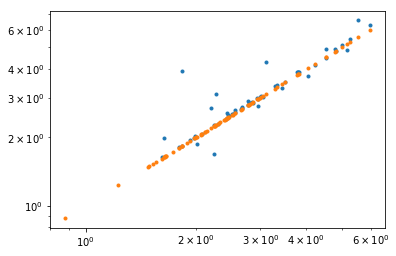

In [11]:
# fit all trials in a channel
sub, i_cond, chan = -1, 0, 2
f_axis = psd_data['f_axis']
fg = FOOOFGroup(peak_width_limits=bw_lims, aperiodic_mode='knee', max_n_peaks=max_n_peaks, verbose=False)
fg.fit(f_axis, power_spec_all[i_cond, :, chan, :], freq_range=freq_range)
# grab aperiodic parameter fits
#fg.get_results()
ap = get_fg_ap(fg)
plt.loglog(ap[:,2], bv_all_exp[sub][i_cond,chan,], '.')
plt.loglog(ap[:,2], exp_all[sub][i_cond,chan,], '.')

In [7]:
def get_fg_ap(fg, fill=None):
    if fill is None:
        fill = np.nan
    # grab aperiodic parameter fits    
    ap_collect = np.ones((len(fg), 3 if fg.aperiodic_mode is 'knee' else 2))*fill
    for i_r, res in enumerate(fg.get_results()):
        # loop through to catch non-fits
        if type(res.aperiodic_params) is not type(None):
            ap_collect[i_r, :] = res.aperiodic_params
    
    return ap_collect


In [455]:
ap = get_fg_ap(fg)
plt.loglog(ap[:,2], bv_all_exp[sub][i_cond,chan,], '.')

In [404]:
#tt = echo_utils.convert_knee_val(fg.get_params('aperiodic_params')[:,1], fg.get_params('aperiodic_params')[:,2])[1]
#plt.loglog(tt, bv_all_tau[-1][i_cond,chan,], '.')
power_spec_all.shape

(3, 90, 4, 231)

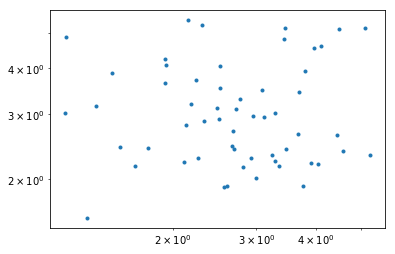

In [458]:
#plt.loglog(ap_params_all[i_cond][chan,:,-1], bv_all_exp[-1][i_cond,chan,], '.')
sub, i_cond, chan = -1, 2, 1
#tt = echo_utils.convert_knee_val(ap_params_all[i_cond][chan,:,1], ap_params_all[i_cond][chan,:,-1])[1]
#plt.loglog(tau_all[sub][i_cond,chan,:], bv_all_tau[sub][i_cond,chan,], '.')
plt.loglog(ap[:,2], bv_all_exp[sub][i_cond,chan,], '.')

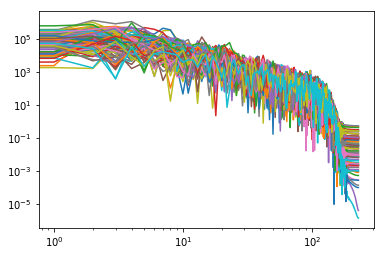

In [428]:
plt.loglog(power_spec_all[1,:,1,:].T);